In [1]:
!pip install networkx numpy
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 84.6 MB/s eta 0:00:00


In [4]:
import networkx as nx
import numpy as np
import gurobipy as gp
from gurobipy import GRB

def get_omega_via_gurobi(graph: nx.Graph) -> int:
    """
    Acts as an oracle to find the clique number omega(G) of a graph.
    It solves the Motzkin-Straus quadratic program using Gurobi.

    The Motzkin-Straus Theorem states:
    max(0.5 * x.T * A * x) for x in the standard simplex = 0.5 * (1 - 1/omega(G))
    where A is the adjacency matrix of the graph.

    Args:
        graph: A networkx graph.

    Returns:
        The integer size of the maximum clique, omega(G).
    """
    n = graph.number_of_nodes()

    # Handle trivial cases
    if n == 0:
        return 0
    # A graph with no edges has n cliques of size 1.
    if graph.number_of_edges() == 0:
        return 1

    # Get the adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)

    try:
        # Create a Gurobi environment and model
        # Note: Gurobi requires a license (free academic licenses are available)
        env = gp.Env(empty=True)
        env.setParam('OutputFlag', 0) # Suppress Gurobi output
        env.start()

        model = gp.Model("motzkin_straus", env=env)
        model.setParam('NonConvex', 2) # Tell Gurobi to use its non-convex QP solver

        # --- Define the variables ---
        # x is a vector of size n, with each element >= 0
        x = model.addMVar(shape=n, name="x", lb=0.0)

        # --- Define the constraints ---
        # The sum of all x_i must equal 1 (standard simplex constraint)
        model.addConstr(x.sum() == 1, "simplex_sum_constraint")

        # --- Define the objective function ---
        # We want to maximize 0.5 * x.T * A * x
        objective = 0.5 * (x @ adj_matrix @ x)
        model.setObjective(objective, GRB.MAXIMIZE)

        # --- Solve the model ---
        model.optimize()

        # --- Calculate omega from the result ---
        # The optimal value is 0.5 * (1 - 1/omega)
        optimal_value = model.ObjVal

        # Avoid division by zero if optimal_value is very close to 0.5
        if abs(0.5 - optimal_value) < 1e-9:
             # This happens for complete graphs where omega=n
             # The objective becomes 0.5 * (1 - 1/n).
             # It can also happen for other graphs if the floating point
             # math aligns. We can directly calculate omega from theory here.
             omega_val = n
        else:
            # 2 * opt_val = 1 - 1/omega
            # 1 - 2 * opt_val = 1/omega
            # omega = 1 / (1 - 2 * opt_val)
            omega_val = 1.0 / (1.0 - 2.0 * optimal_value)

        # Round to the nearest integer to correct for floating point inaccuracies
        return round(omega_val)

    except gp.GurobiError as e:
        print(f"Gurobi error occurred: {e.errno}, {e}")
        return -1
    except Exception as e:
        print(f"An error occurred: {e}")
        return -1

def find_mis_with_oracle(G: nx.Graph, oracle) -> set:
    """
    Constructs a Maximum Independent Set for graph G using an oracle
    that can determine the max clique size of any graph.

    Args:
        G: The input networkx graph.
        oracle: A function that takes a graph and returns its omega value.

    Returns:
        A set of nodes representing one maximum independent set.
    """
    # 1. Find the target size of the MIS (alpha)
    # alpha(G) = omega(G_complement)
    G_complement = nx.complement(G)
    k_target = oracle(G_complement)
    print(f"Oracle reports the MIS size (alpha) for the original graph is: {k_target}")

    mis_nodes = set()
    G_current = G.copy()

    # Iterate over a static copy of the nodes
    for v in list(G.nodes()):
        # If the node was already removed as a neighbor of a selected node, skip.
        if v not in G_current.nodes():
            continue

        # Create a test graph by removing v and its neighbors
        # This represents the remaining problem if we CHOOSE v.
        neighbors_of_v = list(G_current.neighbors(v))
        G_test = G_current.copy()
        G_test.remove_nodes_from([v] + neighbors_of_v)

        # Ask the oracle for the MIS size of the remaining subgraph
        # alpha(G_test) = omega(complement(G_test))
        k_test = oracle(nx.complement(G_test))

        # Check if choosing v leads to a valid path for a maximum independent set
        if 1 + k_test == k_target:
            print(f"  - Testing node {v}... If chosen, we need MIS of size {k_test} from the rest.")
            print(f"    -> 1 + {k_test} == {k_target}. Path is viable. Committing to node {v}.")
            mis_nodes.add(v)

            # The new problem is to find an MIS of size k_target-1 in G_test
            G_current = G_test
            k_target -= 1
        else:
            print(f"  - Testing node {v}... If chosen, we need MIS of size {k_test} from the rest.")
            print(f"    -> 1 + {k_test} != {k_target}. Path is not optimal. Discarding node {v} from this path.")
            # If we don't pick v, the problem space for the next node remains G_current

    return mis_nodes




In [5]:
if __name__ == "__main__":
    print("--- Maximum Independent Set Solver using Motzkin-Straus and Gurobi ---")

    # Create a simple test graph: a 5-cycle graph (C5)
    G_test = nx.cycle_graph(5)
    print("\n1. Created a test graph: 5-cycle (nodes 0-4).")
    print(f"   Nodes: {G_test.nodes()}")
    print(f"   Edges: {G_test.edges()}")

    # We can easily verify the answer for C5
    # Any two non-adjacent nodes form a maximum independent set.
    # The size (alpha) is 2.
    print("\n2. For a 5-cycle graph, we know by inspection that alpha(G) = 2.")
    print("   Example MIS sets: {0, 2}, {0, 3}, {1, 3}, etc.")

    print("\n3. Running the search algorithm with the Gurobi-powered oracle...")

    # The oracle function is passed as an argument
    found_mis = find_mis_with_oracle(G_test, get_omega_via_gurobi)

    print("\n--- Algorithm Finished ---")
    print(f"4. The constructed Maximum Independent Set is: {found_mis}")

    # 5. Verification
    is_independent = all(not G_test.has_edge(u, v) for u in found_mis for v in found_mis if u != v)

    print("\n5. Verifying the result:")
    print(f"   - Is the found set an independent set? -> {is_independent}")
    print(f"   - Is the size of the set ({len(found_mis)}) correct? -> {len(found_mis) == 2}")

    if is_independent and len(found_mis) == 2:
        print("\nSuccess! The algorithm correctly identified a valid Maximum Independent Set.")
    else:
        print("\nFailure. The algorithm produced an incorrect result.")

--- Maximum Independent Set Solver using Motzkin-Straus and Gurobi ---

1. Created a test graph: 5-cycle (nodes 0-4).
   Nodes: [0, 1, 2, 3, 4]
   Edges: [(0, 1), (0, 4), (1, 2), (2, 3), (3, 4)]

2. For a 5-cycle graph, we know by inspection that alpha(G) = 2.
   Example MIS sets: {0, 2}, {0, 3}, {1, 3}, etc.

3. Running the search algorithm with the Gurobi-powered oracle...
Oracle reports the MIS size (alpha) for the original graph is: 2
  - Testing node 0... If chosen, we need MIS of size 1 from the rest.
    -> 1 + 1 == 2. Path is viable. Committing to node 0.
  - Testing node 2... If chosen, we need MIS of size 0 from the rest.
    -> 1 + 0 == 1. Path is viable. Committing to node 2.

--- Algorithm Finished ---
4. The constructed Maximum Independent Set is: {0, 2}

5. Verifying the result:
   - Is the found set an independent set? -> True
   - Is the size of the set (2) correct? -> True

Success! The algorithm correctly identified a valid Maximum Independent Set.


## Version 2 with Visuals

--- Maximum Independent Set Solver using Motzkin-Straus and Gurobi ---

1. Created a test graph: Petersen Graph.
   Nodes: 10
   Edges: 15

2. For the Petersen graph, it is known that alpha(G) = 4.

3. Comparing with a brute-force solver for verification...
   Brute-force solver found an MIS of size: 4
   Brute-force MIS set: {0, 8, 2, 9}

4. Running our search algorithm with the Gurobi-powered oracle...
Oracle reports the MIS size (alpha) for the original graph is: 4
  - Testing node 0... If chosen, need MIS size 3 from rest.
    -> 1 + 3 == 4. Viable. Committing to 0.
  - Testing node 2... If chosen, need MIS size 2 from rest.
    -> 1 + 2 == 3. Viable. Committing to 2.
  - Testing node 6... If chosen, need MIS size 0 from rest.
    -> 1 + 0 != 2. Not optimal. Discarding 6.
  - Testing node 8... If chosen, need MIS size 1 from rest.
    -> 1 + 1 == 2. Viable. Committing to 8.
  - Testing node 9... If chosen, need MIS size 0 from rest.
    -> 1 + 0 == 1. Viable. Committing to 9.

--- 

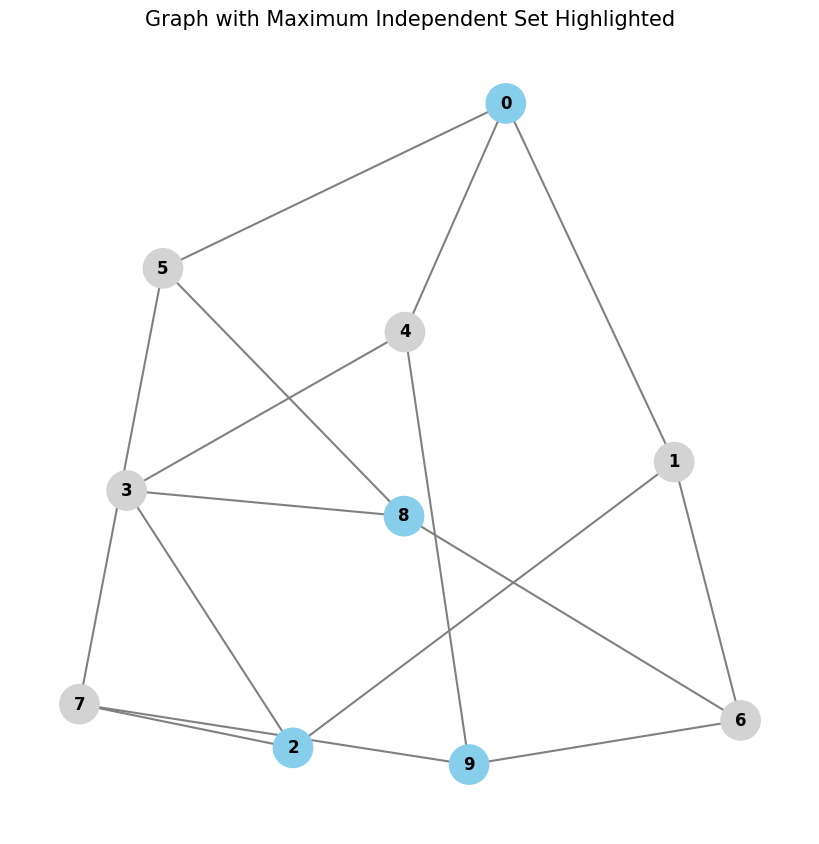

In [6]:
import networkx as nx
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from itertools import combinations

def get_omega_via_gurobi(graph: nx.Graph) -> int:
    """
    Acts as an oracle to find the clique number omega(G) of a graph.
    It solves the Motzkin-Straus quadratic program using Gurobi.

    The Motzkin-Straus Theorem states:
    max(0.5 * x.T * A * x) for x in the standard simplex = 0.5 * (1 - 1/omega(G))
    where A is the adjacency matrix of the graph.

    Args:
        graph: A networkx graph.

    Returns:
        The integer size of the maximum clique, omega(G).
    """
    n = graph.number_of_nodes()

    # Handle trivial cases
    if n == 0:
        return 0
    if graph.number_of_edges() == 0:
        return 1

    adj_matrix = nx.to_numpy_array(graph)

    try:
        env = gp.Env(empty=True)
        env.setParam('OutputFlag', 0)
        env.start()

        model = gp.Model("motzkin_straus", env=env)
        model.setParam('NonConvex', 2)

        x = model.addMVar(shape=n, name="x", lb=0.0)
        model.addConstr(x.sum() == 1, "simplex_sum_constraint")

        objective = 0.5 * (x @ adj_matrix @ x)
        model.setObjective(objective, GRB.MAXIMIZE)
        model.optimize()

        optimal_value = model.ObjVal

        if abs(0.5 - optimal_value) < 1e-9:
             omega_val = n
        else:
            omega_val = 1.0 / (1.0 - 2.0 * optimal_value)

        return round(omega_val)

    except gp.GurobiError as e:
        print(f"Gurobi error occurred: {e.errno}, {e}")
        return -1
    except Exception as e:
        print(f"An error occurred: {e}")
        return -1

def find_mis_with_oracle(G: nx.Graph, oracle) -> set:
    """
    Constructs a Maximum Independent Set for graph G using an oracle
    that can determine the max clique size of any graph.
    """
    G_complement = nx.complement(G)
    k_target = oracle(G_complement)
    print(f"Oracle reports the MIS size (alpha) for the original graph is: {k_target}")

    mis_nodes = set()
    G_current = G.copy()

    for v in list(G.nodes()):
        if v not in G_current.nodes():
            continue

        neighbors_of_v = list(G_current.neighbors(v))
        G_test = G_current.copy()
        G_test.remove_nodes_from([v] + neighbors_of_v)

        k_test = oracle(nx.complement(G_test))

        if 1 + k_test == k_target:
            print(f"  - Testing node {v}... If chosen, need MIS size {k_test} from rest.")
            print(f"    -> 1 + {k_test} == {k_target}. Viable. Committing to {v}.")
            mis_nodes.add(v)
            G_current = G_test
            k_target -= 1
        else:
            print(f"  - Testing node {v}... If chosen, need MIS size {k_test} from rest.")
            print(f"    -> 1 + {k_test} != {k_target}. Not optimal. Discarding {v}.")

    return mis_nodes

def find_mis_brute_force(G: nx.Graph) -> set:
    """Finds the MIS by checking all combinations of nodes."""
    nodes = list(G.nodes())
    n = len(nodes)
    max_is = set()

    # Iterate from largest possible set size down to 1
    for k in range(n, 0, -1):
        for combo in combinations(nodes, k):
            is_independent = True
            # Check if any two nodes in the combo share an edge
            for u, v in combinations(combo, 2):
                if G.has_edge(u, v):
                    is_independent = False
                    break
            if is_independent:
                return set(combo) # First one found is the largest
    return set()

def visualize_mis_solution(G, mis_nodes):
    """Creates and shows a visualization of the graph with MIS nodes highlighted."""
    pos = nx.spring_layout(G, seed=42) # for reproducible layout

    node_colors = []
    for node in G.nodes():
        if node in mis_nodes:
            node_colors.append('skyblue') # Color for MIS nodes
        else:
            node_colors.append('lightgray') # Color for other nodes

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800,
            edge_color='gray', width=1.5, font_size=12, font_weight='bold')

    plt.title("Graph with Maximum Independent Set Highlighted", size=15)
    plt.show()

if __name__ == "__main__":
    print("--- Maximum Independent Set Solver using Motzkin-Straus and Gurobi ---")

    # Use a more complex graph: The Petersen Graph
    G_test = nx.petersen_graph()
    print("\n1. Created a test graph: Petersen Graph.")
    print(f"   Nodes: {G_test.number_of_nodes()}")
    print(f"   Edges: {G_test.number_of_edges()}")

    # The MIS (alpha) for the Petersen graph is 4.
    known_alpha = 4
    print(f"\n2. For the Petersen graph, it is known that alpha(G) = {known_alpha}.")

    print("\n3. Comparing with a brute-force solver for verification...")
    brute_force_mis = find_mis_brute_force(G_test)
    print(f"   Brute-force solver found an MIS of size: {len(brute_force_mis)}")
    print(f"   Brute-force MIS set: {brute_force_mis}")
    if len(brute_force_mis) != known_alpha:
        print("   WARNING: Brute-force result doesn't match known answer!")

    print("\n4. Running our search algorithm with the Gurobi-powered oracle...")
    found_mis = find_mis_with_oracle(G_test, get_omega_via_gurobi)

    print("\n--- Algorithm Finished ---")
    print(f"5. Our constructed Maximum Independent Set is: {found_mis}")

    # 6. Verification
    is_independent = all(not G_test.has_edge(u, v) for u in found_mis for v in found_mis if u != v)
    correct_size = len(found_mis) == known_alpha

    print("\n6. Verifying the result:")
    print(f"   - Is the found set an independent set? -> {is_independent}")
    print(f"   - Is the size of the set ({len(found_mis)}) correct? -> {correct_size}")

    if is_independent and correct_size:
        print("\nSuccess! The algorithm correctly identified a valid Maximum Independent Set.")
        # 7. Visualize the result
        print("\n7. Displaying visualization...")
        visualize_mis_solution(G_test, found_mis)
    else:
        print("\nFailure. The algorithm produced an incorrect result.")

